### CONVOLUTIONAL NEURAL NETWORK

Welcome to Course 4's first assignment! In this assignment, you will implement convolutional (CONV) and pooling (POOL) layers in numpy, including both forward propagation and (optionally) backward propagation. 

**Notation**:
- Superscript $[l]$ denotes an object of the $l^{th}$ layer. 
    - Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.


- Superscript $(i)$ denotes an object from the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example input.
    
    
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$, assuming this is a fully connected (FC) layer.
    
    
- $n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. If you want to reference a specific layer $l$, you can also write $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer. If referencing a specific layer $l$, this could also be denoted $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$. 

We assume that you are already familiar with `numpy` and/or have completed the previous courses of the specialization. Let's get started!|

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
###You will be implementing the building blocks of a convolutional neural network! Each function you will implement will have detailed instructions that will walk you through the steps needed:

##Convolution functions, including:
 ###-Zero Padding
 ###- Convolve window 
 ###- Convolution forward
 ###- Convolution backward (optional)
##Pooling functions, including:
 ###- Pooling forward
 ###- Create mask 
 ###- Distribute value
 ###- Pooling backward (optional)
    

#### Zero padding adds zeros around the border

In [165]:
def zero_pad(X, pad):
    
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    X_pad = np.pad(X, ((0,0),(pad, pad), (pad, pad), (0,0)), 'constant', constant_values = 0)
    
    return X_pad
    

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


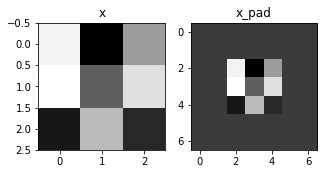

In [166]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x,2)

print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

#### single step convolution 

In [167]:
def conv_single_step(a_slice_prev, W, b):
    
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """""
    Z = np.multiply(a_slice_prev , W) 
    
    Z = np.sum(Z) + float(b)
    
    return Z

In [168]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)

print("Z =", Z)

Z = -6.99908945068


#### Convolution neural network - forward pass

In [177]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    pad = hparameters["pad"]
    stride  = hparameters["stride"]
    f = W.shape[0]
    
    vert_start = 0
    vert_end = ((n_H_prev + 2* pad - f) // stride)+1
    
    horiz_start = 0
    horiz_end = ((n_W_prev + 2*pad -f) // stride) + 1
    
    n_C = W.shape[3]
    
    Z = np.zeros([m,vert_end,horiz_end,n_C])        
 
    A_prev_pad = zero_pad(A_prev, pad)
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev_pad.shape
                  
    for i in range(m): 
        for l in range(n_C):
            for j in range(vert_end):       
                for k in range(horiz_end):
                    j_step = j * stride
                    k_step = k * stride
                    s = conv_single_step(A_prev_pad[i,j_step:j_step+f, k_step:k_step+f,:], W[:,:,:,l], b[:,:,:,l])
                    
                    Z[i,j, k,l] = s
                    
    
    n_H = vert_end
    n_W = horiz_end
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache
                
               
    
    

In [178]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])
print(Z.shape)

Z's mean = 0.0489952035289
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]
(10, 4, 4, 8)


### Pooling layer reduce height and width of the input

#### Forward pooling 

In [179]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    (m, n_H, n_W, n_C) = A_prev.shape
    
    f = hparameters['f']
    stride = hparameters['stride']
    
    n_H_next = ((n_H - f) // stride )+ 1 
    n_W_next = ((n_W - f) // stride ) + 1
    
    A = np.zeros([m, n_H_next, n_W_next, n_C])
    
    for i in range(m):
        for j in range(n_C):
            
            for v in range(n_H_next):
                for h in range(n_W_next):
                    
                    v_step = v * stride
                    h_step = h * stride
                    
                    if mode == 'max' :
                        A[i,v,h,j] = np.max(A_prev[i,v_step:v_step+f,h_step:h_step+f,j])
                    else :
                        A[i,v,h,j] = np.mean(A_prev[i,v_step:v_step+f, h_step:h_step +f , j])
                    
            
    cache = (A_prev, hparameters)
    
    
    return A, cache
    

In [180]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[ 1.74481176  0.86540763  1.13376944]]]


 [[[ 1.13162939  1.51981682  2.18557541]]]]

mode = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]
